In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

import os

def get_figures_path():
    target_suffix = os.path.join("Contrastive_Learning", "code", "ML_model", "figures")
    cwd = os.path.abspath(os.getcwd())
    parts = cwd.split(os.sep)
    for i in range(len(parts), 0, -1):
        candidate = os.sep.join(parts[:i])
        test_path = os.path.join(candidate, target_suffix)
        if os.path.isdir(test_path):
            return test_path
    raise FileNotFoundError(f"Path ending with '{target_suffix}' not found")


Libraries imported successfully.


In [2]:
def load_sota_results(filepath: str) -> pd.DataFrame:
    """
    Dynamically loads tabular data, automatically detecting the separator
    based on the file extension (.tsv, .csv, etc.).
    """
    print(f"Loading SOTA results from: {filepath}")
    
    # Get the file extension from the path
    file_extension = Path(filepath).suffix.lower()
    
    # Choose the separator based on the extension
    if file_extension == '.tsv':
        separator = '\t'
    elif file_extension == '.csv':
        separator = ','
    else:
        # For any other extension, let pandas try to auto-detect.
        # This is often successful for simple, well-formatted files.
        separator = None
        print(f"Warning: Unrecognized extension '{file_extension}'. Letting pandas auto-detect the separator.")
        
    return pd.read_csv(filepath, sep=separator)

def load_single_run_results(results_folder: str, run_name: str=None) -> pd.DataFrame:
    """Loads the Spearman correlation results for a single, specified run."""

    if run_name:
        filepath = Path(results_folder) / run_name / "tsplice_spearman_by_tissue.tsv"
    else:
        filepath = Path(results_folder) / "tsplice_spearman_by_tissue.tsv"
    print(f"Loading single run results from: {filepath}")
    
    # Load the tab-separated file
    df = pd.read_csv(filepath, sep='\t')
    
    # --- ADDED THIS STEP ---
    # Standardize column names to match the expected format ('spearman_rho_...')
    # This handles files that might have the older 'spearman_psi' naming.
    rename_dict = {
        'spearman_psi': 'spearman_rho_psi',
        'spearman_delta': 'spearman_rho_delta_psi'
    }
    df.rename(columns=rename_dict, inplace=True)
    
    return df

def load_and_average_all_runs(results_folder: str) -> pd.DataFrame:
    """
    Finds all 'run_*' directories, loads their results, and computes the mean 
    and standard deviation for performance metrics across all runs.
    """
    all_run_dfs = []
    results_path = Path(results_folder)
    
    run_dirs = sorted([d for d in results_path.iterdir() if d.is_dir() and d.name.startswith('run_')])
    print(f"Found {len(run_dirs)} run directories to average.")

    for run_dir in run_dirs:
        filepath = run_dir / "tsplice_spearman_by_tissue.tsv"
        if filepath.exists():
            df = pd.read_csv(filepath, sep='\t')
            # Handle potential inconsistencies in column naming from your images
            df = df.rename(columns={'spearman_psi': 'spearman_rho_psi', 'spearman_delta': 'spearman_rho_delta_psi'})
            all_run_dfs.append(df)
        else:
            print(f"Warning: Did not find results file in {run_dir}")

    if not all_run_dfs:
        print("Error: No result files were found to average.")
        return pd.DataFrame()

    # Concatenate all dataframes into one
    combined_df = pd.concat(all_run_dfs)
    
    # Group by tissue and calculate mean and standard deviation
    averaged_results = combined_df.groupby('tissue').agg(
        mean_spearman_rho_psi=('spearman_rho_psi', 'mean'),
        std_spearman_rho_psi=('spearman_rho_psi', 'std'),
        mean_spearman_rho_delta_psi=('spearman_rho_delta_psi', 'mean'),
        std_spearman_rho_delta_psi=('spearman_rho_delta_psi', 'std')
    ).reset_index()
    
    print("Successfully averaged results across all runs.")
    return averaged_results

print("Data loading functions defined.")

Data loading functions defined.


In [3]:
def _prepare_single_model_df(df, metric, model_name):
    """Internal helper to prepare one DataFrame for comparison."""
    is_averaged = f'mean_{metric}' in df.columns
    metric_col = f'mean_{metric}' if is_averaged else metric
    std_col = f'std_{metric}' if is_averaged else None

    cols_to_select = ['tissue', metric_col]
    if is_averaged and std_col and std_col in df.columns:
        cols_to_select.append(std_col)
    
    plot_df = df[cols_to_select].copy()
    plot_df.rename(columns={metric_col: model_name}, inplace=True)
    return plot_df

def prepare_grouped_plot_data(df1, df2, metric, model1_name, model2_name):
    """
    Prepares and merges data from two models for a grouped bar plot.

    Args:
        df1 (pd.DataFrame): DataFrame for the first model.
        df2 (pd.DataFrame): DataFrame for the second model.
        metric (str): The base metric name (e.g., 'spearman_rho_psi').
        model1_name (str): Custom name for the first model.
        model2_name (str): Custom name for the second model.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - comparison_df: The merged, wide-format DataFrame.
            - melted_df: The long-format DataFrame ready for seaborn.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)

    # Merge the two prepared dataframes
    comparison_df = pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
    
    # "Melt" the dataframe for seaborn plotting
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=[model1_name, model2_name], 
                                   var_name='Model', value_name='Spearman ρ')
    
    return comparison_df, melted_df

In [4]:
def plot_grouped_comparison(comparison_df, melted_df, title, model1_name, model2_name, save_path=None):
    """
    Generates a grouped bar plot from prepared dataframes.

    Args:
        comparison_df (pd.DataFrame): The merged, wide-format DataFrame.
        melted_df (pd.DataFrame): The long-format DataFrame for plotting.
        title (str): The title for the plot.
        model1_name (str): Name of the first model.
        model2_name (str): Name of the second model.
        save_path (str, optional): Path to save the figure.
    """
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(data=melted_df, x='tissue', y='Spearman ρ', hue='Model', 
                     palette={model1_name: 'lightgray', model2_name: 'mediumseagreen'})
    
    # Add error bars if standard deviation data exists for the second model
    std_col = [col for col in comparison_df.columns if col.startswith('std_')]
    if std_col:
        error_map = comparison_df.set_index('tissue')[std_col[0]].to_dict()
        patches = [p for p in ax.patches if p.get_height() > 0]
        model2_bars = patches[len(patches)//2:] # Second model's bars are the second half
        
        for i, bar in enumerate(model2_bars):
            tissue_name = ax.get_xticklabels()[i].get_text()
            error = error_map.get(tissue_name)
            if pd.notna(error):
                ax.errorbar(x=bar.get_x() + bar.get_width() / 2, y=bar.get_height(), yerr=error,
                            fmt='none', capsize=5, color='black')

    plt.title(title, fontsize=18)
    plt.ylabel('Spearman ρ', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import time # Make sure time is imported

# --- Keep existing helper functions ---
# get_figures_path, logit, get_delta_psi, load_ground_truth,
# load_sota_predictions, load_single_run_predictions,
# calculate_rmse_by_tissue, _prepare_single_model_df (no changes needed)

# --- Keep these data loading functions (or adapt if needed for 3 sources) ---
# from scripts.plot_comparison_metrics_orig import load_sota_results, load_single_run_results, load_and_average_all_runs # Assuming these work for Spearman

# --- MODIFIED: Prepare data for THREE models ---
def prepare_grouped_plot_data_3models(df1, df2, df3, metric, model1_name, model2_name, model3_name):
    """
    Prepares and merges data from THREE models for a grouped bar plot.
    Args are similar to the 2-model version.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)
    model3_plot_df = _prepare_single_model_df(df3, metric, model3_name)

    # Merge the three prepared dataframes sequentially
    comparison_df = pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
    comparison_df = pd.merge(comparison_df, model3_plot_df, on='tissue', how='inner')

    # Define the value name based on the metric
    value_name = 'RMSE (ΔPSI)' if 'rmse' in metric else 'Spearman ρ' # Adjust if needed

    # "Melt" the dataframe for seaborn plotting
    melted_df = comparison_df.melt(
        id_vars='tissue',
        value_vars=[model1_name, model2_name, model3_name], # Include all three model names
        var_name='Model',
        value_name=value_name
        )

    return comparison_df, melted_df

# --- MODIFIED: Plot comparison for THREE models ---
def plot_grouped_comparison_3models(comparison_df, melted_df, title, model1_name, model2_name, model3_name, save_path=None):
    """
    Generates a grouped bar plot for THREE models.
    """
    plt.figure(figsize=(20, 8)) # Increased width for 3 bars

    # Define a color palette (adjust colors as desired)
    palette = {model1_name: 'lightgray', model2_name: 'mediumseagreen', model3_name: 'cornflowerblue'}
    value_col = melted_df.columns[-1] # Get the name of the value column (e.g., 'Spearman ρ')

    ax = sns.barplot(data=melted_df, x='tissue', y=value_col, hue='Model',
                     palette=palette, hue_order=[model1_name, model2_name, model3_name]) # Control order

    # --- Add error bars (handle std dev for potentially multiple models) ---
    std_cols = {
        model_name: col for model_name in [model1_name, model2_name, model3_name]
                       for col in comparison_df.columns if col == f'std_{model_name}' # Construct expected std col name
    }
    
    # Get bars, assuming 3 groups per tissue
    patches = [p for p in ax.patches if p.get_height() != 0] # Exclude zero-height bars if any
    num_models = 3
    num_tissues = len(ax.get_xticklabels())

    if len(patches) == num_models * num_tissues: # Check consistency
        for i in range(num_tissues):
            tissue_name = ax.get_xticklabels()[i].get_text()

            # Bars for model 1, 2, 3 at this tissue index
            bars_for_tissue = patches[i::num_tissues] # Selects every 3rd bar starting from i

            for model_idx, model_name in enumerate([model1_name, model2_name, model3_name]):
                bar = bars_for_tissue[model_idx]
                std_col_name = f'std_{model_name}' # Standard deviation column for this specific model

                # Check if std dev exists for this model in the comparison_df
                if std_col_name in comparison_df.columns:
                    # Get error value specific to this tissue and model
                    error_map = comparison_df.set_index('tissue')[std_col_name].to_dict()
                    error = error_map.get(tissue_name)

                    if pd.notna(error) and error > 0: # Check error is valid
                        ax.errorbar(x=bar.get_x() + bar.get_width() / 2, y=bar.get_height(), yerr=error,
                                    fmt='none', capsize=4, color='black', elinewidth=1)
    else:
         print(f"Warning: Number of bars ({len(patches)}) doesn't match expected ({num_models * num_tissues}). Skipping error bars.")
    # --- End error bar logic ---

    plt.title(title, fontsize=18)
    plt.ylabel(value_col, fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    # else:
    plt.show() # Show plot if not saving
    # plt.close() # Close plot after showing/saving

def plot_average_across_tissues_3models(
    df1, df2, df3, model1_name, model2_name, model3_name,
    metric, save_path=None
):
    """
    Compute and plot the average metric across all tissues for 3 models.
    Each dataframe must contain 'tissue' and the target metric column.

    Args:
        df1, df2, df3: DataFrames containing per-tissue metric values.
        model1_name, model2_name, model3_name: Model labels for legend.
        metric: str, metric column name (e.g. 'spearman_rho_psi').
        save_path: Optional path to save the figure.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Compute averages
    avg_df = pd.DataFrame({
        'Model': [model1_name, model2_name, model3_name],
        'Average': [
            df1[metric].mean(),
            df2[metric].mean(),
            df3[metric].mean()
        ]
    })

    # Determine dynamic y-axis range
    y_min = max(0, avg_df["Average"].min() - 0.05)
    y_max = min(1.0, avg_df["Average"].max() + 0.1)

    # Plot
    plt.figure(figsize=(6, 5))
    sns.barplot(data=avg_df, x='Model', y='Average', palette='viridis')

    plt.ylabel(f"Average {metric.replace('_', ' ').title()}")
    plt.title(f"Average {metric.replace('_', ' ').title()} Across All Tissues")
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()

    # Save and show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved average plot: {save_path}")

    plt.show()
    return avg_df



In [ ]:
################ 2 user inputs WITH SOTA ################

In [ ]:
# # --- Folder 1 ---
# result_file_name1 =  "exprmnt_2025_11_01__12_33_58" # EMPRAIPsi_300bp_MTCLSwept_5Aug_noExonPad_2025_11_01__12_33_58
# model1_user_name_norun = '300bp_MTCLSwept_5Aug_noExonPad'
# model1_user_name = f'{model1_user_name_norun}_ensembled'
# model1_user_avg_name = f'{model1_user_name_norun}_avg'
# model1_runNumber = None


# # --- Folder 2 (Define paths and names for your second experiment) ---
# result_file_name2 =  "exprmnt_2025_11_01__12_32_21" # EMPRAIPsi_300bp_MTCLSwept_10Aug_noExonPad_2025_11_01__12_32_21
# model2_user_name_norun = '300bp_MTCLSwept_10Aug_noExonPad'
# model2_user_name = f'{model2_user_name_norun}_ensembled'
# model2_user_avg_name = f'{model2_user_name_norun}_avg'
# model2_runNumber = None

# result_file_name1 =  "exprmnt_2025_11_03__23_37_19" # EMPRAIPsi_ASCOT_CLSwpd_200bp_5aug_5p3pCut_2025_11_03__23_37_19
# model1_user_name_norun = 'ASCOT_CLSwpd_200bp_5aug_5p3pCut'
# model1_user_name = f'{model1_user_name_norun}_ensembled'
# model1_user_avg_name = f'{model1_user_name_norun}_avg'
# model1_runNumber = None


# # --- Folder 2 (Define paths and names for your second experiment) ---
# result_file_name2 =  "exprmnt_2025_11_03__23_40_11" # EMPRAIPsi_ASCOT_CLSwpd_200bp_10aug_5p3pCut_2025_11_03__23_40_11
# model2_user_name_norun = 'ASCOT_CLSwpd_200bp_10aug_5p3pCut'
# model2_user_name = f'{model2_user_name_norun}_ensembled'
# model2_user_avg_name = f'{model2_user_name_norun}_avg'
# model2_runNumber = None

################################### INTRON ONLY ###################################
# --- Folder 1 ---
# result_file_name1 =  "exprmnt_2025_11_05__01_03_35" # EMPRAIPsi_ASCOT_IntronONLY_CLSwpd_300bp_5aug_5p3pCut_2025_11_05__01_03_35
# model1_user_name_norun = 'ASCOT_IntronONLY_CLSwpd_300bp_5aug'
# model1_user_name = f'{model1_user_name_norun}_ensembled'
# model1_user_avg_name = f'{model1_user_name_norun}_avg'
# model1_runNumber = None


# # --- Folder 2 (Define paths and names for your second experiment) ---
# result_file_name2 =  "exprmnt_2025_11_05__01_02_08" # EMPRAIPsi_ASCOT_IntronONLY_CLSwpd_300bp_10aug_5p3pCut_2025_11_05__01_02_08
# model2_user_name_norun = 'ASCOT_IntronONLY_CLSwpd_300bp_10aug'
# model2_user_name = f'{model2_user_name_norun}_ensembled'
# model2_user_avg_name = f'{model2_user_name_norun}_avg'
# model2_runNumber = None

# # --- Configuration ---
# # --- Folder 1 ---
# result_file_name1 =  "exprmnt_2025_11_05__00_59_03" # EMPRAIPsi_ASCOT_IntronONLY_CLSwpd_200bp_5aug_5p3pCut_2025_11_05__00_59_03
# model1_user_name_norun = 'ASCOT_IntronONLY_CLSwpd_200bp_5aug'
# model1_user_name = f'{model1_user_name_norun}_ensembled'
# model1_user_avg_name = f'{model1_user_name_norun}_avg'
# model1_runNumber = None


# # --- Folder 2 (Define paths and names for your second experiment) ---
# result_file_name2 =  "exprmnt_2025_11_05__01_00_26" # EMPRAIPsi_ASCOT_IntronONLY_CLSwpd_200bp_10aug_5p3pCut_2025_11_05__01_00_26
# model2_user_name_norun = 'ASCOT_IntronONLY_CLSwpd_200bp_10aug'
# model2_user_name = f'{model2_user_name_norun}_ensembled'
# model2_user_avg_name = f'{model2_user_name_norun}_avg'
# model2_runNumber = None

In [ ]:
# --- Assuming imports and previous helper functions are defined ---
# Make sure load_sota_results, load_single_run_results, load_and_average_all_runs are available


# --- Configuration ---
# --- Folder 1 ---
result_file_name1 = "exprmnt_2025_11_01__12_32_21" # EMPRAIPsi_300bp_MTCLSwept_10Aug_noExonPad_2025_11_01__12_32_21
model1_user_name_norun =  '300bp_MTCLSwept_10Aug_noExonPad'
model1_user_name = f'{model1_user_name_norun}_ensembled'
model1_user_avg_name = f'{model1_user_name_norun}_avg'
model1_runNumber = None


# --- Folder 2 (Define paths and names for your second experiment) ---
result_file_name2 =  "exprmnt_2025_11_05__01_00_26" # EMPRAIPsi_ASCOT_IntronONLY_CLSwpd_200bp_10aug_5p3pCut_2025_11_05__01_00_26
model2_user_name_norun = 'ASCOT_IntronONLY_CLSwpd_200bp_10aug'
model2_user_name = f'{model2_user_name_norun}_ensembled'
model2_user_avg_name = f'{model2_user_name_norun}_avg'
model2_runNumber = None


# --- SOTA ---
sota_file_name = "variable_all_tissues_spearman_correlations.tsv" # origianl mtsplice weighted model output
model_sota_name = 'MTSplice_original_SOTA'




In [6]:
# --- Assuming imports and previous helper functions are defined ---
# Make sure load_sota_results, load_single_run_results, load_and_average_all_runs are available


# --- Configuration ---
# --- Folder 1 ---
result_file_name1 = "exprmnt_2025_11_14__12_19_18" # EMPRAIPsi_ASCOT_300bp_MTCLSwept_10Aug_testdata_2025_11_14__12_19_18
model1_user_name_norun =  '300bp_MTCLSwept_10Aug_testdata'
model1_user_name = f'{model1_user_name_norun}_ensembled'
model1_user_avg_name = f'{model1_user_name_norun}_avg'
model1_runNumber = None


# --- Folder 2 (Define paths and names for your second experiment) ---
result_file_name2 =  "exprmnt_2025_11_05__01_00_26" # EMPRAIPsi_ASCOT_IntronONLY_CLSwpd_200bp_10aug_5p3pCut_2025_11_05__01_00_26
model2_user_name_norun = 'ASCOT_IntronONLY_CLSwpd_200bp_10aug'
model2_user_name = f'{model2_user_name_norun}_ensembled'
model2_user_avg_name = f'{model2_user_name_norun}_avg'
model2_runNumber = None


# --- SOTA ---
sota_file_name = "test_all_tissues_spearman_correlations.tsv" # origianl mtsplice weighted model output
model_sota_name = 'MTSplice_original_SOTA'




In [7]:
# --- Base Dirs ---
main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
# main_dir = "/mnt/home/at3836/Contrastive_Learning/files/results/"
fig_maindir = get_figures_path()
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")

# --- Full Paths ---
SOTA_FILE_PATH = f"{main_dir}/mtsplice_originalTFweight_results/intron_300bp_results/{sota_file_name}"
# RESULTS_FOLDER_PATH1 = f"{main_dir}/{result_file_name1}/weights/checkpoints"
RESULTS_FOLDER_PATH1 = f"{main_dir}/{result_file_name1}/ensemble_evaluation_from_valdiation/test_set_evaluation" # <<< Path for Folder 1
RESULTS_FOLDER_PATH2 = f"{main_dir}/{result_file_name2}/ensemble_evaluation_from_valdiation/test_set_evaluation" # <<< Path for Folder 2

In [8]:
# --- Load Data ---
print("--- Loading Data ---")
try:
    # SOTA results
    sota_results = load_sota_results(SOTA_FILE_PATH)
    print(f"Loaded SOTA: {SOTA_FILE_PATH}")

    # Results for Folder 1 (Single Run & Averaged)
    # single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH1, model1_runNumber)
    # averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH1)
    # print(f"Loaded Folder 1: {result_file_name1}")

    single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH1)
    averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH1)
    print(f"Loaded Folder 1: {result_file_name1}")

    # Results for Folder 2 (Single Run & Averaged)
    single_run_2_results = load_single_run_results(RESULTS_FOLDER_PATH2)
    averaged_run_2_results = load_and_average_all_runs(RESULTS_FOLDER_PATH2)
    print(f"Loaded Folder 2: {result_file_name2}")

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    exit()

--- Loading Data ---
Loading SOTA results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results//mtsplice_originalTFweight_results/intron_300bp_results/test_all_tissues_spearman_correlations.tsv
Loaded SOTA: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results//mtsplice_originalTFweight_results/intron_300bp_results/test_all_tissues_spearman_correlations.tsv
Loading single run results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_14__12_19_18/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_spearman_by_tissue.tsv
Found 0 run directories to average.
Error: No result files were found to average.
Loaded Folder 1: exprmnt_2025_11_14__12_19_18
Loading single run results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_05__01_00_26/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_spearman_by_tissue.tsv
Found 0 run directories to average.
Error: No result files 

In [9]:
import pandas as pd

# === Step 1: Load Spearman results ===



import pandas as pd

# --- Load both series ---
spearman_series = single_run_1_results["spearman_rho_delta_psi"]
tissue_series   = single_run_1_results.get("tissue")  # or the correct key once confirmed

if tissue_series is None:
    raise KeyError("No tissue names found in single_run_1_results. Check available keys.")

# --- Build the dataframe ---
spearman_df = pd.DataFrame({
    "tissue": tissue_series,
    "spearman_rho_delta_psi": spearman_series
})
print(f"✅ Combined DataFrame with {spearman_df.shape[0]} tissues")
print(spearman_df.head())

# --- Load tissue class info ---
tissue_class_df = pd.read_csv("/gpfs/commons/home/atalukder/Contrastive_Learning/data/ASCOT/tissue_counts_detailed_ExonBinPsi.csv")[
    ["Tissue", "SampleClass"]
].rename(columns={"Tissue": "tissue", "SampleClass": "SampleClass"})

# --- Merge on tissue name ---
spearman_df["tissue"] = spearman_df["tissue"].astype(str).str.strip()
tissue_class_df["tissue"] = tissue_class_df["tissue"].astype(str).str.strip()

merged = pd.merge(spearman_df, tissue_class_df, on="tissue", how="inner")
print(f"✅ Merged successfully: {merged.shape[0]} matched tissues")

# --- Compute summary stats ---
summary = (
    merged.groupby("SampleClass")["spearman_rho_delta_psi"]
    .agg(["count", "mean", "std", "min", "max", "median"])
    .reset_index()
)
print("\n📊 Spearman correlation summary by sample-size class:\n")
print(summary.to_string(index=False))



✅ Combined DataFrame with 56 tissues
                       tissue  spearman_rho_delta_psi
0               Adrenal Gland                0.267525
1            Amygdala - Brain                0.112326
2  Anterior cingulate - Brain                0.130272
3              Aorta - Artery                0.119770
4    Atrial Appendage - Heart                0.019570
✅ Merged successfully: 56 matched tissues

📊 Spearman correlation summary by sample-size class:

  SampleClass  count     mean      std      min      max   median
  High sample      5 0.190351 0.071812 0.151013 0.317892 0.156453
   Low sample      6 0.150681 0.085901 0.078564 0.314716 0.136557
Medium sample     45 0.137481 0.041896 0.019570 0.267525 0.134493


✅ Merged successfully: 112 entries, columns = ['tissue', 'spearman_rho_delta_psi', 'Model', 'SampleClass']


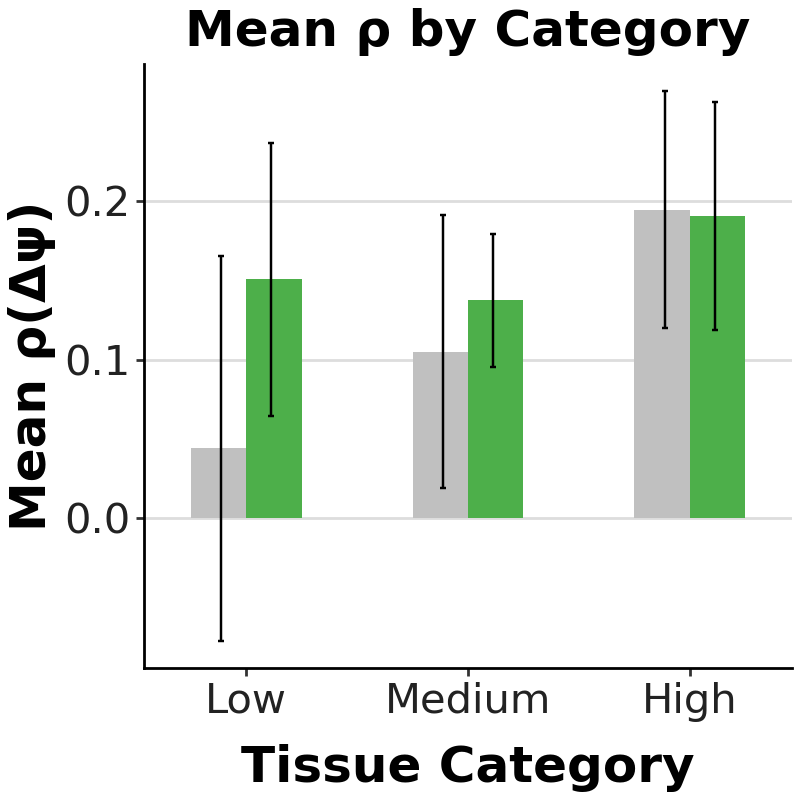

✅ Saved: fig_spearman_SOTA_vs_CLADE_consistent.png (same as notebook view)


In [10]:
# %%
import pandas as pd
import time
from plotnine.themes.elements import element_blank, margin   # ✅ add this line
import matplotlib.pyplot as plt

# === Step 1: Load both results ===
def prepare_df(results, label):
    """Return tidy dataframe with tissue, rho, and SampleClass."""

    
    spearman_series = results["spearman_rho_delta_psi"]
    tissue_series   = results.get("tissue")
    if tissue_series is None:
        raise KeyError("No tissue names found in results.")
    df = pd.DataFrame({
        "tissue": tissue_series,
        "spearman_rho_delta_psi": spearman_series
    })
    df["Model"] = label
    return df

sota_df  = prepare_df(sota_results, "SOTA")
clade_df = prepare_df(single_run_1_results, "CLADES")

# === Step 2: Concatenate both ===
all_df = pd.concat([sota_df, clade_df], ignore_index=True)

# === Step 3: Load tissue classification ===
tissue_class_df = pd.read_csv(
    "/gpfs/commons/home/atalukder/Contrastive_Learning/data/ASCOT/tissue_counts_detailed_ExonBinPsi.csv"
)[["Tissue", "SampleClass"]].rename(columns={"Tissue": "tissue"})

# --- Merge classification info ---
all_df["tissue"] = all_df["tissue"].astype(str).str.strip()
tissue_class_df["tissue"] = tissue_class_df["tissue"].astype(str).str.strip()

merged = pd.merge(all_df, tissue_class_df, on="tissue", how="inner")

# --- Normalize class names ---
merged["SampleClass"] = (
    merged["SampleClass"]
    .str.replace(" sample", "", case=False)
    .str.strip()
    .str.capitalize()
)

print(f"✅ Merged successfully: {merged.shape[0]} entries, columns = {merged.columns.tolist()}")

# === Step 4: Compute mean ± std per class per model ===
summary = (
    merged.groupby(["SampleClass", "Model"])["spearman_rho_delta_psi"]
    .agg(["mean", "std", "count"])
    .reset_index()
)


# Ensure class order for x-axis
summary["SampleClass"] = pd.Categorical(
    summary["SampleClass"], categories=["Low", "Medium", "High"], ordered=True
)





from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar, scale_x_discrete,
    scale_fill_manual, labs, theme_bw, theme,
    element_text, position_dodge
)
from plotnine.themes.elements import element_blank
import matplotlib.pyplot as plt

# Ensure category order
summary["Model"] = pd.Categorical(summary["Model"], ["SOTA", "CLADES"], ordered=True)
summary["SampleClass"] = pd.Categorical(summary["SampleClass"], ["Low", "Medium", "High"], ordered=True)

# Build figure
# p = (
#     ggplot(summary, aes(x="SampleClass", y="mean", fill="Model"))
#     + geom_bar(stat="identity", position=position_dodge(width=0.34), width=0.36)  # tighter grouping
#     + geom_errorbar(
#         aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
#         width=0.06, position=position_dodge(width=0.34)
#     )
#     + scale_fill_manual(values={"SOTA": "#c0c0c0", "CLADE": "#4daf4a"})  # light grey + green
#     + scale_x_discrete(expand=(0.08, 0.01))  # small left margin
#     + labs(x="Tissue type class", y=r"Mean $\boldsymbol{\rho}$", fill=None)
#     + theme_bw()
#     +theme(
#             figure_size=(4, 4),
#             legend_position='none',
#             legend_justification=(0, 1),
#             legend_background=element_blank(),
#             legend_title=element_blank(),
#             legend_text=element_text(size=15),
#             axis_text_x=element_text(
#             size=15, ha="center", va="top", color="#222222"  # ✅ darker tissue names
#         ),
#         axis_text_y=element_text(
#             size=15, color="#222222"  # ✅ darker y-axis tick labels
#         ),
#             axis_title_x=element_text(margin={'t': 8}, size=18, weight="bold"),
#             axis_title_y=element_text(size=20, weight="bold"),
#             plot_title=element_text(size=15, weight="bold", ha="center"),

#             # ✅ Clean look
#             panel_border=element_blank(),             # remove full rectangle
#             panel_grid_major_y=element_text(color="#dddddd"),  # light horizontal grid
#             panel_grid_minor_y=element_blank(),
#             panel_grid_major_x=element_blank(),       # no vertical grid
#             panel_grid_minor_x=element_blank(),

#             # Draw only bottom + left borders
#             axis_line_x=element_text(color="black"),
#             axis_line_y=element_text(color="black"),


      
#         )
# )

p = (
    ggplot(summary, aes(x="SampleClass", y="mean", fill="Model"))
    + geom_bar(stat="identity", position=position_dodge(width=0.5), width=0.5)  # ✅ balanced
    + geom_errorbar(
        aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
        width=0.05, position=position_dodge(width=0.45)
    )
    + scale_fill_manual(values={"SOTA": "#c0c0c0", "CLADES": "#4daf4a"})
    + scale_x_discrete(expand=(0.08, 0.01))
    + labs(x="Tissue Category", y="Mean ρ(Δψ)", title="Mean ρ by Category", fill=None)
    + theme_bw()
    + theme(
        figure_size=(4, 4),
        legend_position='none',
        axis_text_x=element_text(size=15, ha="center", va="top", color="#222222"),
        axis_text_y=element_text(size=15, color="#222222"),
        axis_title_x=element_text(margin={'t': 8}, size=18, weight="bold"),
        axis_title_y=element_text(size=18, weight="bold"),
        plot_title=element_text(size=18, weight="bold", ha="center"),
        panel_border=element_blank(),
        panel_grid_major_y=element_text(color="#dddddd"),
        panel_grid_minor_y=element_blank(),
        panel_grid_major_x=element_blank(),
        panel_grid_minor_x=element_blank(),
        axis_line_x=element_text(color="black"),
        axis_line_y=element_text(color="black"),
    )
)

# === Step 6: Display & save ===
p.show()

out_path = f"/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_meanSP_SOTA_vs_CLADE_{time.strftime('%Y%m%d_%H%M%S')}"

# --- Draw and save with consistent size ---
fig = p.draw()

# Force the figure to match notebook display ratio
fig.set_size_inches(4, 4)  # same as theme figure_size

formats = ['png', 'svg', 'pdf', 'eps']
# for fmt in formats:
#     save_path = f"{out_path}.{fmt}"
#     fig.savefig(
#     save_path,
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white"
#     )
#     print(f"✅ Saved: {save_path}")


plt.close(fig)
print("✅ Saved: fig_spearman_SOTA_vs_CLADE_consistent.png (same as notebook view)")


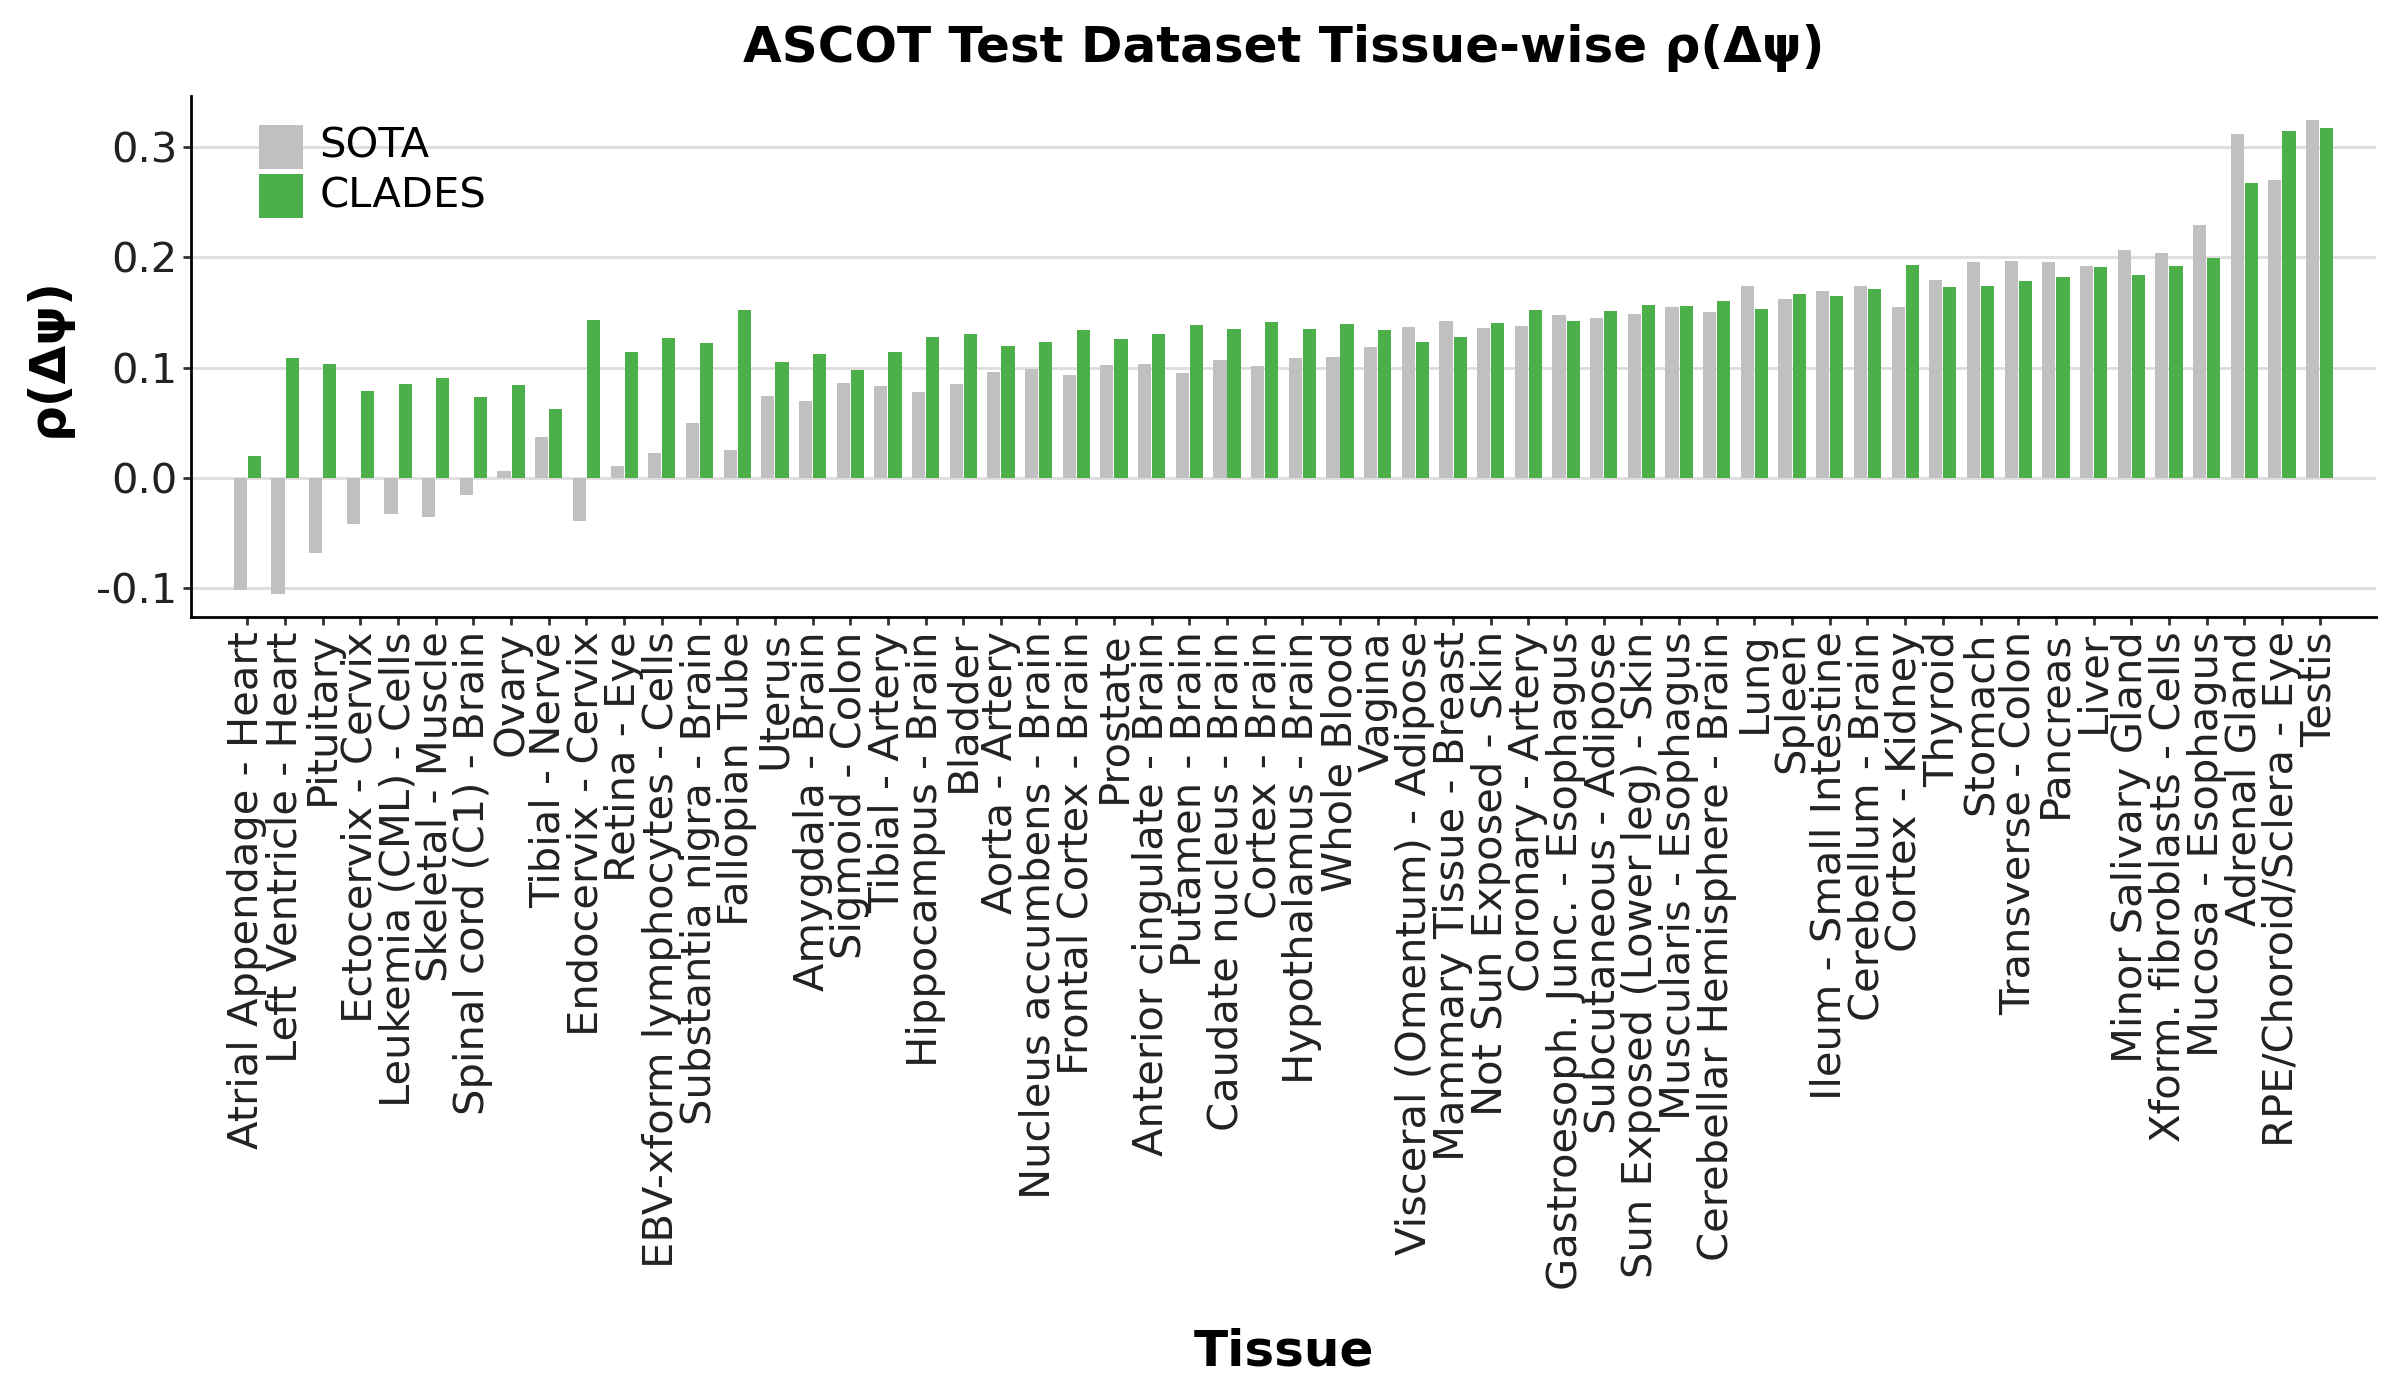

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testdata_spearman_rho_delta_psi_SOTA_vs_CLADE_20251116_011628.eps
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testdata_spearman_rho_delta_psi_SOTA_vs_CLADE_20251116_011628.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testdata_spearman_rho_delta_psi_SOTA_vs_CLADE_20251116_011628.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testdata_spearman_rho_delta_psi_SOTA_vs_CLADE_20251116_011628.pdf


In [22]:
from plotnine import (
    ggplot, aes, geom_bar, scale_fill_manual, labs, theme_bw, theme,
    element_text, element_blank, position_dodge, scale_x_discrete
)

import time
import matplotlib.pyplot as plt


def plot_tissuewise_spearman_barplot(sota_df, run1_df, metric_col, main_dir):
    """
    Create a tissue-wise barplot comparing SOTA vs SingleRun1 (Δψ or PSI Spearman).
    
    Args:
        sota_df: pd.DataFrame with ['tissue', metric_col]
        run1_df: pd.DataFrame with ['tissue', metric_col]
        metric_col: str, e.g., 'spearman_rho_delta_psi' or 'spearman_rho_psi'
        main_dir: directory for saving
    """
    # --- Standardize + merge ---
    sota_df = sota_df[["tissue", metric_col]].assign(Model="SOTA")
    run1_df = run1_df[["tissue", metric_col]].assign(Model="CLADES")

    merged = pd.concat([sota_df, run1_df], ignore_index=True)

    # --- Enforce order by mean across both models for visual consistency ---
    tissue_order = (
        merged.groupby("tissue")[metric_col]
        .mean()
        .sort_values(ascending=True)
        .index
        .tolist()
    )
    merged["tissue"] = pd.Categorical(merged["tissue"], categories=tissue_order, ordered=True)

    # ✅ Ensure SOTA always comes before CLADE in legend & dodge position
    merged["Model"] = pd.Categorical(merged["Model"], categories=["SOTA", "CLADES"], ordered=True)


    # --- Build plot ---
    p = (
        ggplot(merged, aes(x="tissue", y=metric_col, fill="Model"))
        + geom_bar(stat="identity", position=position_dodge(width=0.75), width=0.7)
        + scale_fill_manual(values={"SOTA": "#c0c0c0", "CLADES": "#4daf4a"})
        + scale_x_discrete(expand=(0.02, 0.02))
        + labs(
            x="Tissue",
            y="ρ(Δψ)",
            title="ASCOT Test Dataset Tissue-wise ρ(Δψ)",
            fill=None
        )
        + theme_bw()
        + theme(
            figure_size=(12, 7),
            legend_position=(0.03, 0.95),
            legend_justification=(0, 1),
            legend_background=element_blank(),
            legend_title=element_blank(),
            legend_text=element_text(size=15),
            axis_text_x=element_text(
            size=15, angle=90, ha="center", va="top", color="#222222"  # ✅ darker tissue names
        ),
        axis_text_y=element_text(
            size=15, color="#222222"  # ✅ darker y-axis tick labels
        ),
            axis_title_x=element_text(margin={'t': 8}, size=18, weight="bold"),
            axis_title_y=element_text(size=18, weight="bold"),
            plot_title=element_text(size=18, weight="bold", ha="center"),

            # ✅ Clean look
            panel_border=element_blank(),             # remove full rectangle
            panel_grid_major_y=element_text(color="#dddddd"),  # light horizontal grid
            panel_grid_minor_y=element_blank(),
            panel_grid_major_x=element_blank(),       # no vertical grid
            panel_grid_minor_x=element_blank(),

            # Draw only bottom + left borders
            axis_line_x=element_text(color="black"),
            axis_line_y=element_text(color="black"),

            # panel_border=element_blank(),          # remove outer box
            # panel_grid_major=element_blank(),      # remove major grid from theme_bw
            # panel_grid_minor=element_blank(),
            # axis_line_x=element_text(color="black"),  # make sure axes are black
            # axis_line_y=element_text(color="black")
      
        )
    )
    

    # --- Display in notebook ---
    p.show()

    # --- Save ---
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    out_path = f"{main_dir}/fig_TissueWise_ASCOT_testdata_{metric_col}_SOTA_vs_CLADE_{timestamp}"
    fig = p.draw()
    fig.set_size_inches(12, 7)

    for fmt in ["eps", "png", "svg", "pdf"]:
        save_path = f"{out_path}.{fmt}"
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
            facecolor="white"
        )
        print(f"✅ Saved: {save_path}")

    plt.close(fig)

main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"

plot_tissuewise_spearman_barplot(
    sota_df=sota_results,
    run1_df=single_run_1_results,
    metric_col="spearman_rho_delta_psi",
    main_dir=main_dir
)



/scratch/ipykernel_194928/3311466176.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


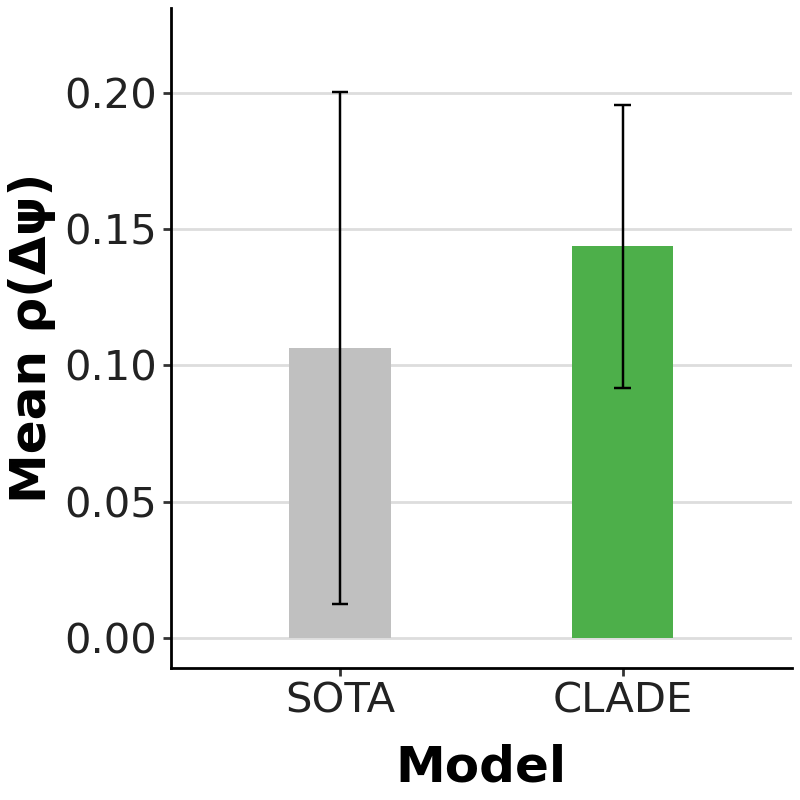

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testdata_mean_spearman_rho_delta_psi_SOTA_vs_CLADE_20251116_011640.eps
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testdata_mean_spearman_rho_delta_psi_SOTA_vs_CLADE_20251116_011640.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testdata_mean_spearman_rho_delta_psi_SOTA_vs_CLADE_20251116_011640.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TissueWise_ASCOT_testdata_mean_spearman_rho_delta_psi_SOTA_vs_CLADE_20251116_011640.pdf


In [23]:
from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar, scale_fill_manual,
    labs, theme_bw, theme, element_text, element_blank, position_dodge, coord_cartesian
)
from xml.etree import ElementTree as ET
import pandas as pd
import time
import matplotlib.pyplot as plt


def plot_mean_spearman_summary(sota_df, run1_df, metric_col, main_dir):
    """
    Compute mean ± std of Spearman correlation across all tissues for each model
    and plot a compact summary barplot (SOTA vs CLADE).
    """
    #  --- Standardize + merge ---
    sota_df = sota_df[["tissue", metric_col]].assign(Model="SOTA")
    run1_df = run1_df[["tissue", metric_col]].assign(Model="CLADE")
    merged = pd.concat([sota_df, run1_df], ignore_index=True)

    # --- Enforce desired model order ---
    merged["Model"] = pd.Categorical(merged["Model"], categories=["SOTA", "CLADE"], ordered=True)

    # --- Compute mean ± std ---
    summary = (
        merged.groupby("Model")[metric_col]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    # --- Plot ---
    p = (
        ggplot(summary, aes(x="Model", y="mean", fill="Model"))
        + geom_bar(stat="identity", width=0.36)
        + geom_errorbar(
            aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
            width=0.06
        )
        + scale_fill_manual(values={"SOTA": "#c0c0c0", "CLADE": "#4daf4a"})
        + labs(x=None, 
            y="Mean ρ(Δψ)", fill=None)
        + theme_bw()
        + coord_cartesian(ylim=(-0.0, 0.22))  # ✅ preferred approach
        # + theme(
        #     figure_size=(4, 4),
        #     legend_position="none",
        #     axis_text_x=element_text(size=13, weight="bold"),
        #     axis_text_y=element_text(size=12),
        #     axis_title_y=element_text(size=13, weight="bold"),
        #     axis_title_x=element_text(margin={'t': 8}, size=13, weight="bold"),
        #     panel_border=element_blank(),
        #     panel_grid_major_y=element_text(color="#dddddd"),
        #     panel_grid_minor_y=element_blank(),
        #     panel_grid_major_x=element_blank(),
        #     panel_grid_minor_x=element_blank(),
        #     axis_line_x=element_text(color="black"),
        #     axis_line_y=element_text(color="black"),
        #     plot_title=element_blank()
        # )
        + theme(
            figure_size=(4, 4),
            legend_position="none",
            axis_text_y=element_text(size=15, color="#222222"),
            axis_text_x=element_text(size=15, color="#222222"),
            axis_title_x=element_text(margin={'t': 8}, size=18, weight="bold"),
            axis_title_y=element_text(size=18, weight="bold"),
            plot_title=element_text(size=15, weight="bold", ha="center"),
            panel_border=element_blank(),
            panel_grid_major_y=element_text(color="#dddddd"),
            panel_grid_minor_y=element_blank(),
            panel_grid_major_x=element_blank(),
            panel_grid_minor_x=element_blank(),
            axis_line_x=element_text(color="black"),
            axis_line_y=element_text(color="black"),
        )
    )

    # --- Display in notebook ---
    p.show()

    # --- Save ---
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    out_path = f"{main_dir}/fig_TissueWise_ASCOT_testdata_mean_{metric_col}_SOTA_vs_CLADE_{timestamp}"
    
    
    fig = p.draw()
    fig.set_size_inches(4, 3)
    def normalize_svg_viewbox(svg_path, target_size=(400, 400)):
        tree = ET.parse(svg_path)
        root = tree.getroot()
        root.set("width", f"{target_size[0]}")
        root.set("height", f"{target_size[1]}")
        root.set("viewBox", f"0 0 {target_size[0]} {target_size[1]}")
        tree.write(svg_path)

    for fmt in ["eps", "png", "svg", "pdf"]:
        save_path = f"{out_path}.{fmt}"
        fig.savefig(
            save_path,
            dpi=300,
            facecolor="white",
            bbox_inches="tight", pad_inches=0
        )
        if fmt == "svg":
            normalize_svg_viewbox(save_path)
        print(f"✅ Saved: {save_path}")

    plt.close(fig)

main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"


plot_mean_spearman_summary(
    sota_df=sota_results,
    run1_df=single_run_1_results,
    metric_col="spearman_rho_delta_psi",
    main_dir="/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"
)



--- Plotting Single Run Comparison ---
Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/spearman_rho_psi_MTSplice_original_SOTA_vs_300bp_MTCLSwept_10Aug_testdata_ensembled_vs_ASCOT_IntronONLY_CLSwpd_200bp_10aug_ensembled_2025_11_16__00_53_39.png


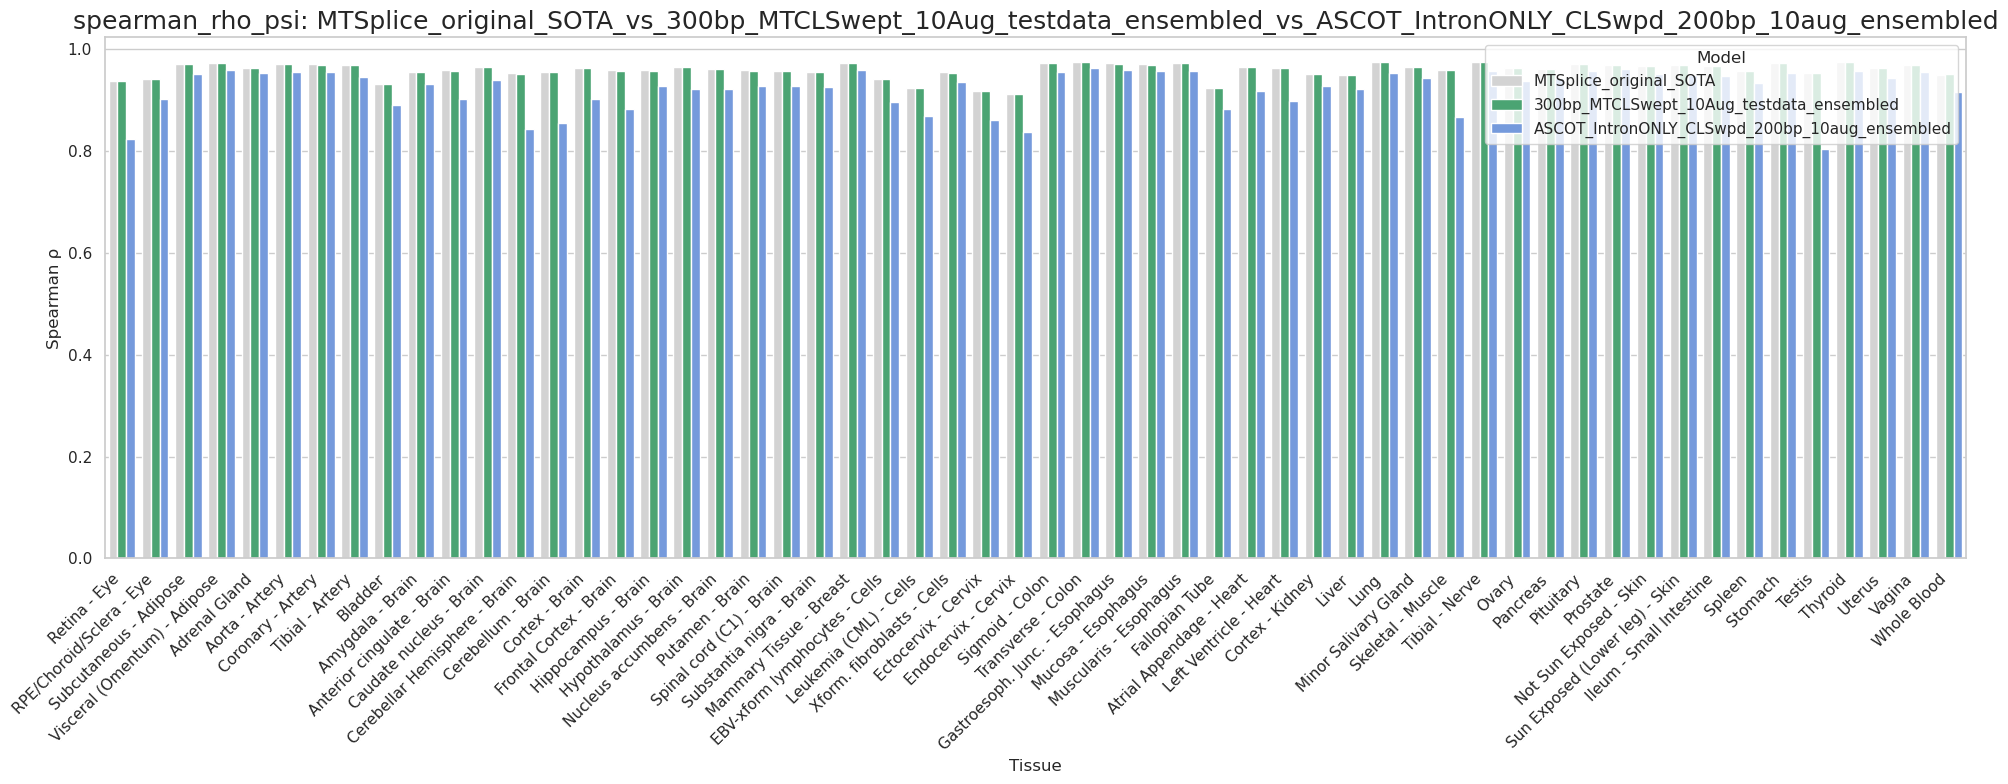

Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/spearman_rho_delta_psi_MTSplice_original_SOTA_vs_300bp_MTCLSwept_10Aug_testdata_ensembled_vs_ASCOT_IntronONLY_CLSwpd_200bp_10aug_ensembled_2025_11_16__00_53_39.png


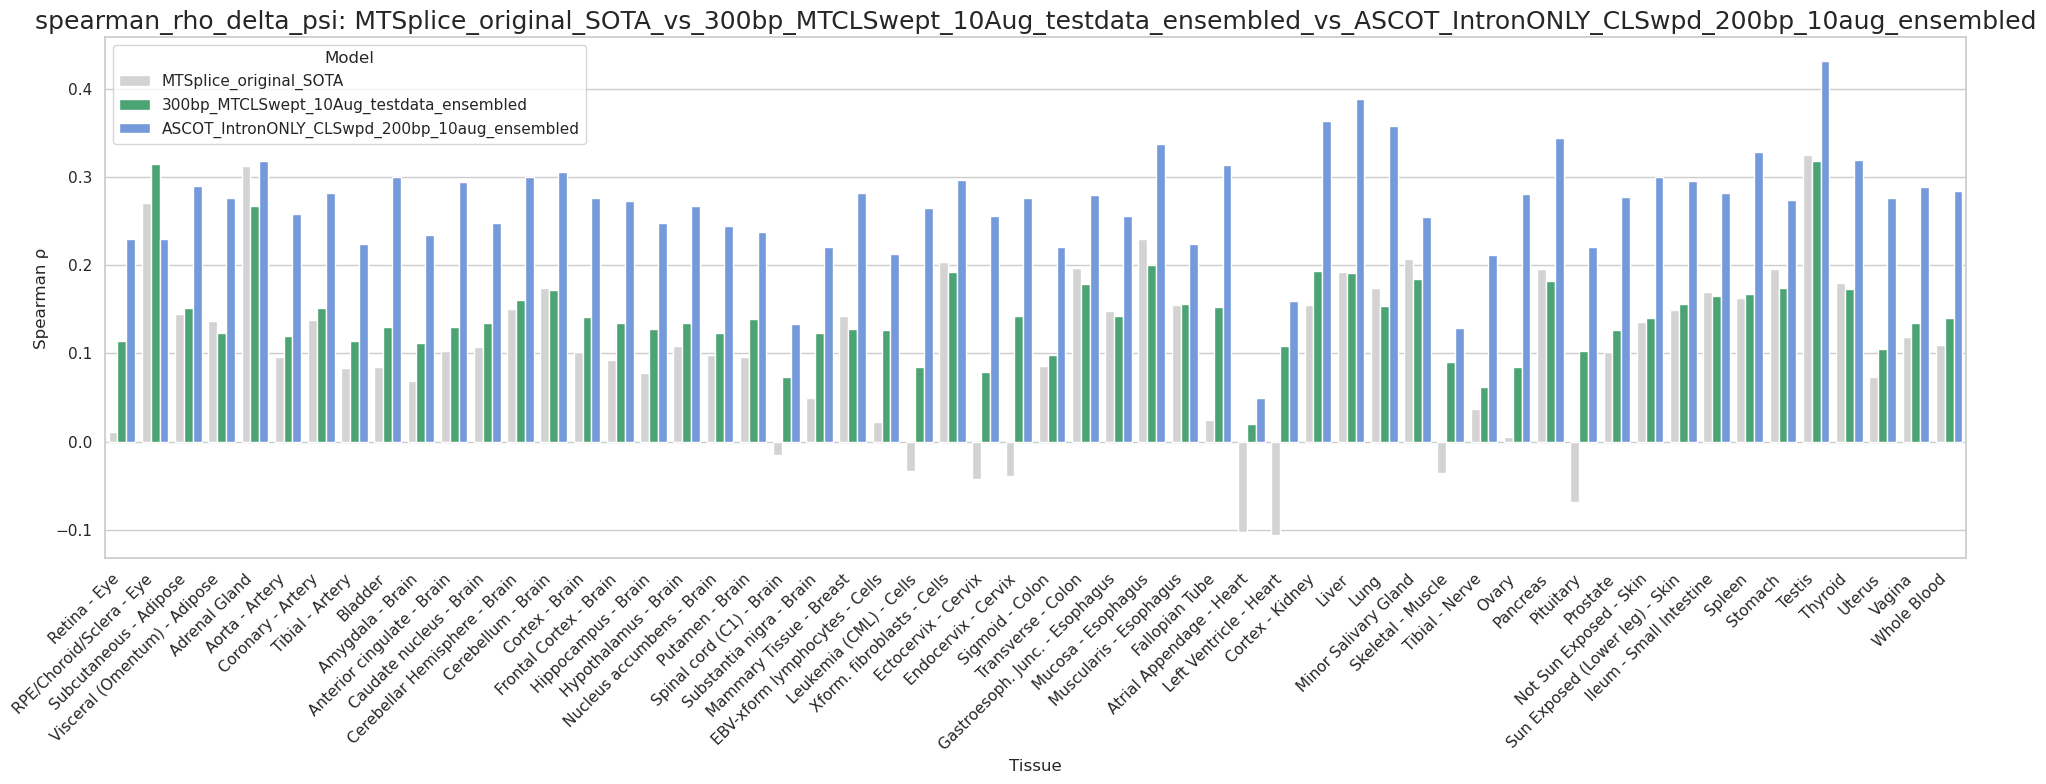

In [13]:
# --- Plotting ---

# --- Plot 1: Single Runs Comparison (SOTA vs Run1 vs Run2) ---
print("\n--- Plotting Single Run Comparison ---")
title_single = f"{model_sota_name}_vs_{model1_user_name}_vs_{model2_user_name}"
metric_psi = 'spearman_rho_psi'
metric_delta = 'spearman_rho_delta_psi'

# Plot for spearman_rho_psi
try:
    comp_df_s1, melt_df_s1 = prepare_grouped_plot_data_3models(
        df1=sota_results,
        df2=single_run_1_results,
        df3=single_run_2_results,
        metric=metric_psi,
        model1_name=model_sota_name,
        model2_name=model1_user_name,
        model3_name=model2_user_name
    )
    plot_grouped_comparison_3models(
        comp_df_s1, melt_df_s1,
        title=f'{metric_psi}: {title_single}',
        model1_name=model_sota_name,
        model2_name=model1_user_name,
        model3_name=model2_user_name,
        save_path=f"{fig_maindir}/{metric_psi}_{title_single}{trimester}.png"
    )
except KeyError as e:
    print(f"Error preparing/plotting {metric_psi} for single runs: Missing column - {e}")
except Exception as e:
    print(f"An unexpected error occurred plotting {metric_psi} for single runs: {e}")


# Plot for spearman_rho_delta_psi
try:
    comp_df_s2, melt_df_s2 = prepare_grouped_plot_data_3models(
        df1=sota_results,
        df2=single_run_1_results,
        df3=single_run_2_results,
        metric=metric_delta,
        model1_name=model_sota_name,
        model2_name=model1_user_name,
        model3_name=model2_user_name
    )
    plot_grouped_comparison_3models(
        comp_df_s2, melt_df_s2,
        title=f'{metric_delta}: {title_single}',
        model1_name=model_sota_name,
        model2_name=model1_user_name,
        model3_name=model2_user_name,
        save_path=f"{fig_maindir}/{metric_delta}_{title_single}{trimester}.png"
    )
except KeyError as e:
    print(f"Error preparing/plotting {metric_delta} for single runs: Missing column - {e}")
except Exception as e:
    print(f"An unexpected error occurred plotting {metric_delta} for single runs: {e}")


--- Plotting Average Spearman Correlations Across All Tissues ---


/scratch/ipykernel_194928/1920585798.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



✅ Saved average plot: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/avg_spearman_rho_psi_MTSplice_original_SOTA_vs_300bp_MTCLSwept_10Aug_testdata_ensembled_vs_ASCOT_IntronONLY_CLSwpd_200bp_10aug_ensembled_2025_11_16__00_53_39.png


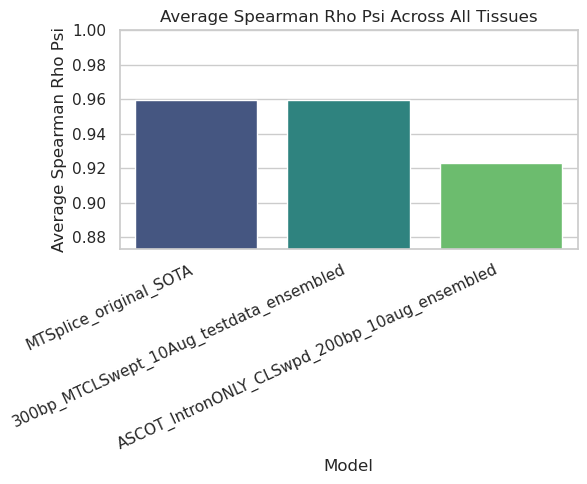

/scratch/ipykernel_194928/1920585798.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



✅ Saved average plot: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/avg_spearman_rho_delta_psi_MTSplice_original_SOTA_vs_300bp_MTCLSwept_10Aug_testdata_ensembled_vs_ASCOT_IntronONLY_CLSwpd_200bp_10aug_ensembled_2025_11_16__00_53_39.png


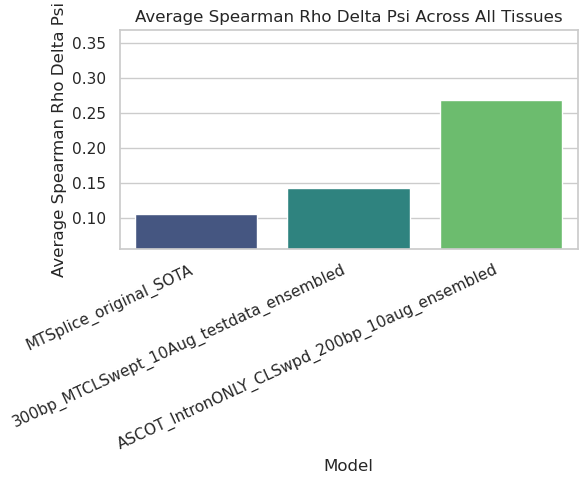


--- Average Summary ---
                                           Model   Average
0                         MTSplice_original_SOTA  0.959611
1       300bp_MTCLSwept_10Aug_testdata_ensembled  0.959365
2  ASCOT_IntronONLY_CLSwpd_200bp_10aug_ensembled  0.923284
                                           Model   Average
0                         MTSplice_original_SOTA  0.106385
1       300bp_MTCLSwept_10Aug_testdata_ensembled  0.143616
2  ASCOT_IntronONLY_CLSwpd_200bp_10aug_ensembled  0.268183


In [14]:
print("\n--- Plotting Average Spearman Correlations Across All Tissues ---")

avg_psi = plot_average_across_tissues_3models(
    sota_results, single_run_1_results, single_run_2_results,
    model_sota_name, model1_user_name, model2_user_name,
    metric='spearman_rho_psi',
    save_path=f"{fig_maindir}/avg_{metric_psi}_{title_single}{trimester}.png"
)

avg_delta = plot_average_across_tissues_3models(
    sota_results, single_run_1_results, single_run_2_results,
    model_sota_name, model1_user_name, model2_user_name,
    metric='spearman_rho_delta_psi',
    save_path=f"{fig_maindir}/avg_{metric_delta}_{title_single}{trimester}.png"
)

print("\n--- Average Summary ---")
print(avg_psi)
print(avg_delta)


In [ ]:
# --- Plot 2: Averaged Runs Comparison (SOTA vs Avg1 vs Avg2) ---
print("\n--- Plotting Averaged Run Comparison ---")
title_avg = f"{model_sota_name}_vs_{model1_user_avg_name}_vs_{model2_user_avg_name}"

# Plot for spearman_rho_psi (using averaged results)
try:
    comp_df_a1, melt_df_a1 = prepare_grouped_plot_data_3models(
        df1=sota_results, # SOTA doesn't need averaging
        df2=averaged_run_1_results,
        df3=averaged_run_2_results,
        metric=metric_psi, # Function will look for mean_spearman_rho_psi etc.
        model1_name=model_sota_name,
        model2_name=model1_user_avg_name,
        model3_name=model2_user_avg_name
    )
    plot_grouped_comparison_3models(
        comp_df_a1, melt_df_a1,
        title=f'{metric_psi}: {title_avg}',
        model1_name=model_sota_name,
        model2_name=model1_user_avg_name,
        model3_name=model2_user_avg_name,
        save_path=f"{fig_maindir}/{metric_psi}_{title_avg}{trimester}.png"
    )
except KeyError as e:
    print(f"Error preparing/plotting {metric_psi} for averaged runs: Missing column - {e}")
except Exception as e:
    print(f"An unexpected error occurred plotting {metric_psi} for averaged runs: {e}")


# Plot for spearman_rho_delta_psi (using averaged results)
try:
    comp_df_a2, melt_df_a2 = prepare_grouped_plot_data_3models(
        df1=sota_results,
        df2=averaged_run_1_results,
        df3=averaged_run_2_results,
        metric=metric_delta,
        model1_name=model_sota_name,
        model2_name=model1_user_avg_name,
        model3_name=model2_user_avg_name
    )
    plot_grouped_comparison_3models(
        comp_df_a2, melt_df_a2,
        title=f'{metric_delta}: {title_avg}',
        model1_name=model_sota_name,
        model2_name=model1_user_avg_name,
        model3_name=model2_user_avg_name,
        save_path=f"{fig_maindir}/{metric_delta}_{title_avg}{trimester}.png"
    )
except KeyError as e:
    print(f"Error preparing/plotting {metric_delta} for averaged runs: Missing column - {e}")
except Exception as e:
    print(f"An unexpected error occurred plotting {metric_delta} for averaged runs: {e}")

print("\n--- Script Finished ---")

In [ ]:
################ 2 user inputs WITH SOTA ################

In [ ]:
################ 2 user inputs WITH SOTA ################
################ mtsplice original vs user input ################

In [ ]:
# 1. Load the SOTA data

# --- Please update these paths ---

# 1. Path to your State-of-the-Art (SOTA) results file.
#    This file should have at least 'tissue', 'spearman_rho_psi', 'spearman_rho_delta_psi' columns.
# result_file_name = "exprmnt_2025_10_22__23_40_20" # newMTmodel
# result_file_name = "exprmnt_2025_10_22__23_35_53" # newMTmodel

########
# result_file_name = "exprmnt_2025_10_22__23_34_30" # newMTmodelCLBCEFixedSpecies
# model1_name = 'MTSplice_original'
# model2_name_norun = 'MTspliceNewModelCLFixedSpeciesBCE'
# model2_runNumber = 'run_2'

# #######
# result_file_name = "exprmnt_2025_10_24__16_05_34" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_
# model2_name_norun = 'MTspliceNewModelCLAllSpeciesBCE'
# model2_runNumber = 'run_6'

# ########
# result_file_name = "exprmnt_2025_10_24__16_07_40" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_wtdSupCon
# model2_name_norun = 'MTspliceNewModelWtdCLAllSpeciesBCE'
# model2_runNumber = 'run_4'

########
# result_file_name = "exprmnt_2025_10_25__22_38_22" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_wtdSupCon_noASCOTTestinTrain_2025_10_25__22_38_22
# model2_name_norun = 'MTSplNew_AllSpcs_BCE_wtdSupCon_noASCOTTestinTrain'
# model2_runNumber = 'run_20'

########
# result_file_name = "exprmnt_2025_10_24__04_01_01" # newMTmodel_300bp intron
# model2_name_norun = 'MTspliceNewModel_NoCL_300bpintron'
# model2_runNumber = 'run_20'

In [ ]:
########
result_file_name = "exprmnt_2025_10_27__02_07_52" # newMTmodel_300bp intron_sweep
model2_name_norun = 'sweep'
model2_runNumber = 'lr_0.001__do_0.1__bs_1024__accum_1'



sota_file_name = "variable_all_tissues_spearman_correlations.tsv" # origianl mtsplice weighted model output
model1_name = 'MTSplice_original_SOTA'

model2_name = f'{model2_name_norun}_{model2_runNumber}'
main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
# main_dir = "/mnt/home/at3836/Contrastive_Learning/files/results/"
SOTA_FILE_PATH = f"{main_dir}/mtsplice_originalTFweight_results/intron_300bp_results/{sota_file_name}"

# 2. Path to the main folder containing all your experiment runs (e.g., run_1, run_2, etc.)
RESULTS_FOLDER_PATH = f"{main_dir}/{result_file_name}/weights/checkpoints"


In [ ]:
# --- Assume these DataFrames are already loaded ---

# SOTA results
sota_results = load_sota_results(SOTA_FILE_PATH)

# Results for a single run
single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH, model2_runNumber)
# print(single_run_1_results.head())

# Averaged results from one set of runs
averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH)
# print(get_figures_path())


In [ ]:
# Prepare the data SINGLE RUN 1 vs SOTA

title = f"{model1_name}_VS_{model2_name}"
import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=single_run_1_results,
    metric='spearman_rho_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'spearman_rho_psi: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=single_run_1_results,
    metric='spearman_rho_delta_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'delta PSI Correlation: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title}{trimester}.png"
)

In [ ]:
# Prepare the data

# Prepare the data average folder 1 vs SOTA

model2_name = f'{model2_name_norun}_avg'

title = f"{model1_name}_VS_{model2_name}"
import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=averaged_run_1_results,
    metric='spearman_rho_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'spearman_rho_psi: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=averaged_run_1_results,
    metric='spearman_rho_delta_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'delta PSI Correlation: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title}{trimester}.png"
)



In [ ]:
################ mtsplice original vs user input ################

In [ ]:
################ 2 user inputs ################

In [ ]:
# 1. Load the SOTA data

# --- Please update these paths ---

# 1. Path to your State-of-the-Art (SOTA) results file.
#    This file should have at least 'tissue', 'spearman_rho_psi', 'spearman_rho_delta_psi' columns.

# result_file_name = "exprmnt_2025_10_19__16_56_25" # ntv2
# result_file_name2 = "exprmnt_2025_10_20__15_11_51" # ntv2_CLtrained

# result_file_name = "exprmnt_2025_08_26__17_44_28" # mtsplice our training
# result_file_name2 = "exprmnt_2025_10_16__13_39_45" # resnet, 10 aug, intron, exon

# result_file_name = "exprmnt_2025_08_26__17_44_28" # mtsplice our training
# result_file_name2 = "exprmnt_2025_10_20__15_18_32" # resnet, 10 aug, intron, exon, weighted

# result_file_name = "exprmnt_2025_10_16__13_39_45" # resnet, 10 aug, intron, exon
# result_file_name2 = "exprmnt_2025_10_20__15_18_32" # resnet, 10 aug, intron, exon, weighted

########
# result_file_name = "exprmnt_2025_10_22__23_40_20" # newMTmodel
# result_file_name2 = "exprmnt_2025_10_22__23_35_53" # newMTmodelCLMSEFixedSpecies

# model1_name_norun = 'MTspliceNewModel_NoCL'
# model2_name_norun = 'MTspliceNewModelCLFixedSpeciesMSE'

# model1_runNumber = 'run_13'
# model2_runNumber = 'run_15'

# ########
# result_file_name = "exprmnt_2025_10_22__23_40_20" # newMTmodel
# result_file_name2 = "exprmnt_2025_10_22__23_34_30" # newMTmodelCLBCEFixedSpecies

# model1_name_norun = 'MTspliceNewModel_NoCL'
# model2_name_norun = 'MTspliceNewModelCLFixedSpeciesBCE'

# model1_runNumber = 'run_13'
# model2_runNumber = 'run_2'

# ########
# result_file_name = "exprmnt_2025_10_22__23_34_30" # newMTmodelCLBCEFixedSpecies
# result_file_name2 = "exprmnt_2025_10_24__16_05_34" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_

# model1_name_norun = 'MTspliceNewModelCLFixedSpeciesBCE'
# model2_name_norun = 'MTspliceNewModelCLAllSpeciesBCE'

# model1_runNumber = 'run_2'
# model2_runNumber = 'run_6'


#######
# result_file_name = "exprmnt_2025_10_22__23_40_20" # newMTmodel
# result_file_name2 = "exprmnt_2025_10_24__04_01_01" # newMTmodel_300bp intron

# model1_name_norun = 'MTspliceNewModel_NoCL'
# model2_name_norun = 'MTspliceNewModel_NoCL_300bpintron'

# model1_runNumber = 'run_13'
# model2_runNumber = 'run_20'


# ########
# result_file_name = "exprmnt_2025_10_24__16_05_34" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_
# result_file_name2 = "exprmnt_2025_10_24__16_07_40" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_wtdSupCon


# model1_name_norun = 'MTspliceNewModelCLAllSpeciesBCE'
# model2_name_norun = 'MTspliceNewModelWtdCLAllSpeciesBCE'

# model1_runNumber = 'run_6'
# model2_runNumber = 'run_4'




########
# result_file_name = "exprmnt_2025_10_25__22_41_13" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_noASCOTTestinTrain
# result_file_name2 = "exprmnt_2025_10_25__22_38_22" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_wtdSupCon_noASCOTTestinTrain_2025_10_25__22_38_22


# model1_name_norun = 'MTSplNew_AllSpcs_BCE_noASCOTTestinTrain'
# model2_name_norun = 'MTSplNew_AllSpcs_BCE_wtdSupCon_noASCOTTestinTrain'

# model1_runNumber = 'run_20'
# model2_runNumber = 'run_20'

# # ########
# result_file_name = "exprmnt_2025_10_24__16_07_40" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_wtdSupCon
# result_file_name2 = "exprmnt_2025_10_25__22_38_22" # EMPRAIPsi_MTSplNew_AllSpcs_BCE_wtdSupCon_noASCOTTestinTrain_2025_10_25__22_38_22


# model1_name_norun = 'MTspliceNewModelWtdCLAllSpeciesBCE'
# model2_name_norun = 'MTSplNew_AllSpcs_BCE_wtdSupCon_noASCOTTestinTrain'

# model1_runNumber = 'run_4'
# model2_runNumber = 'run_20'

In [ ]:




#######
result_file_name = "exprmnt_2025_10_22__23_40_20" # newMTmodel
result_file_name2 = "exprmnt_2025_10_24__04_01_01" # newMTmodel_300bp intron

model1_name_norun = 'MTspliceNewModel_NoCL'
model2_name_norun = 'MTspliceNewModel_NoCL_300bpintron'

model1_runNumber = 'run_13'
model2_runNumber = 'run_20'

In [ ]:
model1_name = f'{model1_name_norun}_{model1_runNumber}'
model2_name = f'{model2_name_norun}_{model2_runNumber}'

main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
# main_dir = "/mnt/home/at3836/Contrastive_Learning/files/results/"


# 2. Path to the main folder containing all your experiment runs (e.g., run_1, run_2, etc.)
RESULTS_FOLDER_PATH = f"{main_dir}/{result_file_name}/weights/checkpoints"
RESULTS_FOLDER_PATH2 = f"{main_dir}/{result_file_name2}/weights/checkpoints"


In [ ]:
# --- Assume these DataFrames are already loaded ---

# SOTA results
# sota_results = load_sota_results(SOTA_FILE_PATH)

# Results for a single run
single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH, model1_runNumber)
# print(f"single_run_1_results {single_run_1_results.head()}")

# Results for another single run (from a different experiment/user)
single_run_2_results = load_single_run_results(RESULTS_FOLDER_PATH2, model2_runNumber)
# print(f"single_run_2_results {single_run_2_results.head()}")


# Averaged results from one set of runs
averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH)
# print(f"average_folder1_results {averaged_run_1_results.head()}")


# Averaged results from another set of runs
averaged_run_2_results = load_and_average_all_runs(RESULTS_FOLDER_PATH2)
# print(f"average_folder2_results {averaged_run_2_results.head()}")


In [ ]:
# Prepare the data
# Prepare the data SINGLE RUN 1 vs SINGLE RUN 2

title = f"{model1_name}_VS_{model2_name}"
import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    metric='spearman_rho_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'spearman_rho_psi: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    metric='spearman_rho_delta_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'delta PSI Correlation: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title}{trimester}.png"
)





In [ ]:
# Prepare the data
model1_name = f'{model1_name_norun}_avg'
model2_name = f'{model2_name_norun}_avg'

title = f"{model1_name}_VS_{model2_name}"

import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=averaged_run_1_results,
    df2=averaged_run_2_results,
    metric='spearman_rho_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'spearman_rho_psi: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=averaged_run_1_results,
    df2=averaged_run_2_results,
    metric='spearman_rho_delta_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'delta PSI Correlation: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title}{trimester}.png"
)



In [ ]:
######################################